# Transformer


In [1]:
import math
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import utils
from ts2vec import datautils

In [2]:
BATCH_SIZE = 25
NUM_EPOCHS = 200

## 1. 数据预处理

预处理步骤：

1. 将数据集分割成训练数据和验证数据
2. 用 SentimentDataset 将训练数据和验证数据做成数据集
3. 用 DataLoader 加载训练集和验证集



```python
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(seq, dtype=torch.float32) for seq in X]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def collate_fn(batch):
    """对变长序列进行 padding，并生成 src_key_padding_mask"""
    X_batch, y_batch = zip(*batch)

    X_batch_padded = pad_sequence(X_batch, batch_first=True, padding_value=0.0)
    y_batch_tensor = torch.stack(y_batch)

    lengths = torch.tensor([len(x) for x in X_batch])
    src_key_padding_mask = torch.arange(X_batch_padded.size(1)) \
        .expand(len(X_batch), X_batch_padded.size(1)) >= lengths.unsqueeze(1)

    return X_batch_padded, y_batch_tensor, src_key_padding_mask
```

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(seq, dtype=torch.float32) for seq in X]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def collate_fn(batch):
    """对变长序列进行 padding，并生成 src_key_padding_mask"""
    X_batch, y_batch = zip(*batch)

    X_batch_padded = pad_sequence(X_batch, batch_first=True, padding_value=0.0)
    y_batch_tensor = torch.stack(y_batch)

    lengths = torch.tensor([len(x) for x in X_batch])
    src_key_padding_mask = torch.arange(X_batch_padded.size(1)) \
        .expand(len(X_batch), X_batch_padded.size(1)) >= lengths.unsqueeze(1)

    return X_batch_padded, y_batch_tensor, src_key_padding_mask

In [5]:
# 分割训练集和验证集
X_train, y_train, X_val, y_val = datautils.load_UCR('ECG200')

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [6]:
# 判断时间序列是不是定长序列，如果不是定长序列，添加 padding
is_fixed = True
first_len = X_train.shape[1]
for X in X_train[1:]:
    if(X.shape[0] != first_len):
        is_fixed = False
        break

print(f'Is fixed length sequence: {is_fixed}')
collate_fn = None if is_fixed else collate_fn

# 用 DataLoader 加载数据
train_iter = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        collate_fn=collate_fn)
val_iter = DataLoader(val_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      collate_fn=collate_fn)

Is fixed length sequence: True


In [7]:
# 打印 train_iter 的第一行数据
for X, y in train_iter:
    print(f'X.shape: {X.shape}')
    print(f'y.shape: {y.shape}')
    X_shape = X.shape
    break

X.shape: torch.Size([25, 96, 1])
y.shape: torch.Size([25])


## 2. 定义模型

模型结构如下：

- Transformer Encoder
- 单层 MLP
- Softmax

训练完成后，把 MLP 和 Softmax 丢掉，将 `Transformer Encoder` 作为特征抽取器。

In [8]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        assert seq_len <= self.max_len, "Sequence length exceeds max_len"

        return x + self.pe[:, :seq_len].to(x.device)

In [9]:
# Transformer + MLP 分类器
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, hidden_dim, num_classes):
        super().__init__()

        # 输入嵌入层和位置编码
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        # Transformer 编码器
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(model_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, src, src_key_padding_mask=None, need_mlp=True):
        # 输入嵌入和位置编码
        src = self.embedding(src) * math.sqrt(src.size(-1))
        src = self.pos_encoder(src)

        # Transformer Encoder (使用 padding mask 来忽略填充的部分)
        transformer_out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

        # Average pooling over the sequence dimension, ignoring padding
        if src_key_padding_mask is not None:
            mask = (~src_key_padding_mask).float().unsqueeze(-1)  # (batch_size, sequence_length, 1)
            transformer_out = transformer_out * mask  # Mask the padded positions
            sum_out = transformer_out.sum(dim=1)  # Sum over the sequence length
            avg_out = sum_out / mask.sum(dim=1).clamp(min=1)  # Divide by the actual sequence lengths
        else:
            avg_out = transformer_out.mean(dim=1)  # Average pooling over sequence length

        if need_mlp:
            return self.mlp(avg_out)

        return avg_out

In [10]:
# 定义模型
net = TransformerClassifier(input_dim=X_shape[2],
                              model_dim=8,
                              nhead=4,
                              num_layers=2,
                              hidden_dim=32,
                              num_classes=2)

# 权重初始化
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Embedding):
        torch.nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 如果有 GPU，把模型复制到 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [11]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 优化器
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

## 3. 训练模型

In [12]:
def evaluate_accuracy(net, data_iter, device):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = utils.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for data in data_iter:
            if is_fixed:
                X_batch, y_batch = data
                X_batch = X_batch.to(device)
                y = y_batch.to(device)
                src_key_padding_mask = None
            else:
                X_batch, y_batch, src_key_padding_mask = data
                X_batch = X_batch.to(device)
                y = y_batch.to(device)
                src_key_padding_mask = src_key_padding_mask.to(device)
    
            # 计算梯度并更新参数
            y_hat = net(X_batch, src_key_padding_mask=src_key_padding_mask)
            metric.add(utils.accuracy(y_hat, y), y.numel())

    return metric[0] / metric[1]

In [13]:
def train_epoch(net, train_iter, loss, updater, device):
    """训练模型一个迭代周期"""

    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    net.to(device)

    # 训练损失总和、训练准确度总和、样本数
    metric = utils.Accumulator(3)
    for data in train_iter:

        if is_fixed:
            X_batch, y_batch = data
            X_batch = X_batch.to(device)
            y = y_batch.to(device)
            src_key_padding_mask = None
        else:
            X_batch, y_batch, src_key_padding_mask = data
            X_batch = X_batch.to(device)
            y = y_batch.to(device)
            src_key_padding_mask = src_key_padding_mask.to(device)

        # 计算梯度并更新参数
        y_hat = net(X_batch, src_key_padding_mask=src_key_padding_mask)
        l = loss(y_hat, y)

        # 使用 PyTorch 内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        metric.add(float(l.sum()), utils.accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [14]:
def train(net, train_iter, test_iter, loss, num_epochs, updater, device):
    """训练模型"""
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater, device)
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    print(f'train_loss: {train_loss:.3f}')
    print(f'train_acc: {train_acc:.3f}')
    print(f'test_acc: {test_acc:.3f}')

train_loss: 0.235
train_acc: 0.880
test_acc: 0.810


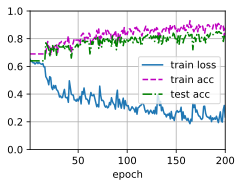

In [15]:
train(net=net,
      train_iter=train_iter,
      test_iter=val_iter,
      loss=loss,
      num_epochs=NUM_EPOCHS,
      updater=optimizer,
      device=device)

## 4. 预测

In [16]:
# 预测标签
for X_val, y_val in val_iter:
        break

net.eval()
print('net(X_val).argmax(axis=1): \n'
      f'    {net(X_val).argmax(axis=1)}')
print('y_val: \n'
      f'    {y_val}')

net(X_val).argmax(axis=1): 
    tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0])
y_val: 
    tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0])


In [17]:
# 将 transformer encode 作为特征提取器
ts_embedding = net(X_val, need_mlp=False)
ts_embedding.shape, ts_embedding

(torch.Size([25, 8]),
 tensor([[ 0.7024,  0.6309,  0.1388, -0.2115,  0.5270, -0.6802, -0.9811, -0.6989],
         [ 1.0652,  0.7547,  0.2748, -0.2206,  0.6455, -0.5914, -1.3239, -1.4257],
         [ 0.7435,  0.6394,  0.1535, -0.2116,  0.5358, -0.6612, -1.0134, -0.7865],
         [-0.0369,  0.4078, -0.1015, -0.2232,  0.3134, -0.8996, -0.3167,  0.7817],
         [ 0.7943,  0.6552,  0.1751, -0.2118,  0.5500, -0.6401, -1.0581, -0.9044],
         [ 0.6677,  0.6281,  0.1366, -0.2213,  0.5227, -0.7004, -0.9569, -0.6258],
         [ 0.7050,  0.6533,  0.1630, -0.2363,  0.5411, -0.7135, -1.0017, -0.6802],
         [ 0.9985,  0.7439,  0.2457, -0.2204,  0.6286, -0.6410, -1.2690, -1.2510],
         [ 0.4725,  0.5703,  0.0780, -0.2286,  0.4621, -0.7616, -0.7775, -0.2289],
         [ 0.5210,  0.5863,  0.1001, -0.2313,  0.4781, -0.7496, -0.8256, -0.3269],
         [-0.0497,  0.3918, -0.1174, -0.2122,  0.3051, -0.8890, -0.2994,  0.8044],
         [ 0.6893,  0.6308,  0.1423, -0.2178,  0.5267, -0.6854, -